## 🎹 Spotify popularity analysis
---

The goal of this study is to determine specific criterias that a song's popularity depends on. We are going to answer the following questions :
- ⏳ Which duration should be prioritized to be popular in **pop** music ?
- 🥁 Which tempo should be prioritized to be popular in **pop** music ?
- 🗨️ Which words should be prioritized to be popular in **pop** music ?

In order to do this, we will use the following [dataset](https://www.kaggle.com/datasets/conorvaneden/best-songs-on-spotify-for-every-year-2000-2023?select=Best+Songs+on+Spotify+from+2000-2023.csv) available on Kaggle.

> 🧰 Let's first import all the packages that we will need for this study.

In [2]:
from dotenv import load_dotenv

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

import os
import requests
import string
import warnings

load_dotenv()
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)

## 🗺️ 1. Dataset exploration
---

Let's start by loading and exploring the dataset in order to identify the data that will help us in this study.

Here's what our data looks like. It seems obvious that the column we are going to focus on is the `popularity` column.

In [3]:
# Load the dataset from the previously downloaded file
df = pd.read_csv("./data/Best Songs on Spotify from 2000-2023.csv", delimiter=";")

# Show the first rows to have an idea of what the data looks like
df.head(3)

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96


### ⚠️ 1.0.1 Data cleaning
Before going any further, we should check if there are any empty or NaN values in our DataFrame.

In [4]:
df[df.isna().any(axis=1)]

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity


In [5]:
df[df.isnull().any(axis=1)]

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity


We should create a new column in our DataFrame that will create popularity groups and help for visualization purposes. For this, we are going to split our popularity column into 4 groups using quartiles.

In [6]:
df["popularity_cat"] = pd.qcut(df["popularity"], q=4, labels=["Low", "Medium", "High", "Super High"])
df.head(3)

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity,popularity_cat
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98,Super High
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97,Super High
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96,Super High


### ↪️ 1.1 Pop songs extraction

As you may have noticed, there are multiple genres but the only one that interests us is "pop". We should create a new DataFrame called `pop_df` that will contain only pop songs that we will use in the next steps.

> 👉 Our new DataFrame looks like this :

In [7]:
# Use boolean indexing to filter our main DataFrame
pop_df = df[df["top genre"] == "pop"]

# Show the first rows of our brand new data
pop_df.head(3)

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity,popularity_cat
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98,Super High
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96,Super High
8,Anti-Hero,Taylor Swift,pop,2022,97,64,64,-7,14,53,201,13,5,94,Super High


## ⏳ 2. Which duration should be prioritized ?
---

We are going to use a scatter plot in order to figure out which duration is to be prioritized for pop music.

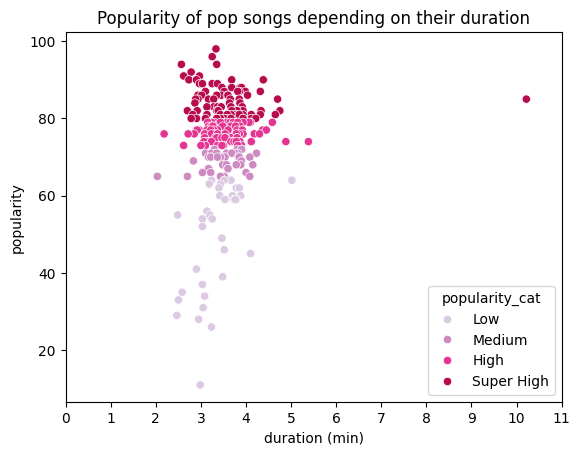

In [8]:
sns.scatterplot(data=pop_df, x="duration", y="popularity", hue="popularity_cat", palette="PuRd")
ax = plt.gca()

ax.set_xticks(range(0, max(df['duration']) + 1, 60))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x / 60)}"))
plt.title("Popularity of pop songs depending on their duration")
plt.xlabel("duration (min)")
plt.show()

> 💡 It looks like the duration to be prioritized in order to make a popular pop song is around **3 minutes**.

## 🥁 3. Which tempo should be prioritized ?
---

Here we are going to compare the popularity of pop songs with their tempo in order to find a correlation between those data.

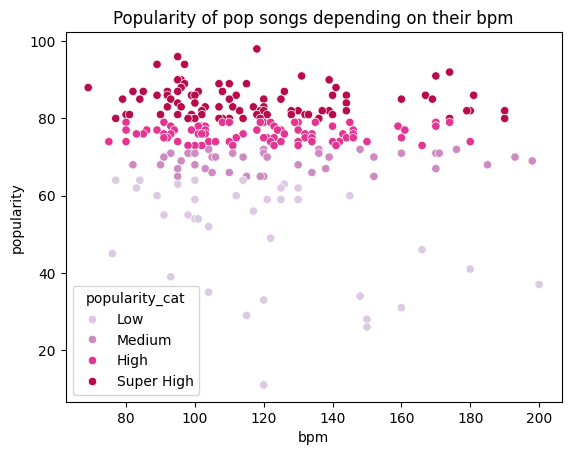

In [9]:
sns.scatterplot(data=pop_df, x="bpm", y="popularity", hue="popularity_cat", palette="PuRd")

plt.title("Popularity of pop songs depending on their bpm")
plt.show()

> ⛔ This graph is not relevant because it looks like the popular songs are scattered all around it. Still, we can observe that there is a higher **density** of dots between 90 and 140 bpm.\
> Our next step is to draw a histogram in order to put a value on that density and identify which bpm are the popular songs composed of.

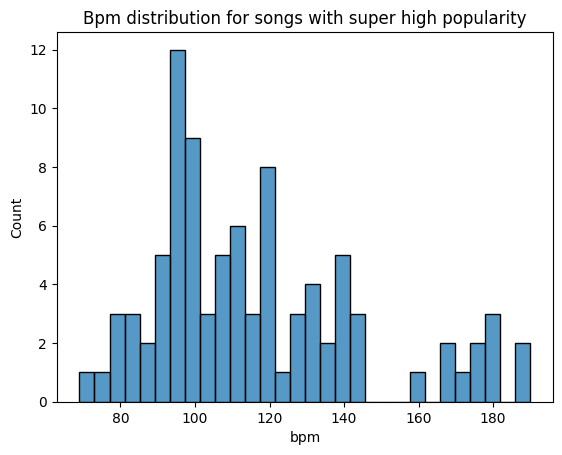

In [10]:
# Create a smaller DataFrame composed of the most popular songs
popular_df = pop_df[pop_df["popularity_cat"] == "Super High"]
popular_df.reset_index()

# Draw a histogram counting the amount of those songs on 30 different bpm
sns.histplot(data=popular_df, x="bpm", stat="count", bins=30)

plt.title("Bpm distribution for songs with super high popularity")
plt.show()

💡 It looks like the popular pop songs have a tempo between 90 and 120 bpm, even though the tempo that is the most present in popular songs is around 95 bpm.

## 4. 🗨️ Which words should be prioritized ?
---

In order to figure out which words the most popular songs are made of, we are going to need to fetch the song lyrics from the genius API using `lyricsgenius`. First, let's make a single request to check what the raw lyrics look like.
> ⚠️ To run this block you will need to set the `GENIUS_ACCESS_TOKEN` environment variable containing a token generated from [this page](https://genius.com/api-clients). You can store it in a `.env` file, but make sure to run the first block to load the `.env` file after you set the variable in it.

In [11]:
from lyricsgenius import Genius
from lyricsgenius.song import Song

# Instanciate the genius client once
genius = Genius(os.environ["GENIUS_ACCESS_TOKEN"])


def search_song_lyrics(song: dict) -> Song | None:
    """Search for song lyrics using the Genius API

    Args:
        song (dict): An object containing "title" and "artist" keys to search for.

    Returns:
        Song | None: The found song, or None if nothing is found
    """
    try:
        return genius.search_song(song["title"], song["artist"], get_full_info=False)
    except Exception:
        print(f"Failed to fetch lyrics for {song['title']} | {song['artist']}.")
        return None

In [12]:
# Search for a single song to see what our lyrics look like
song = search_song_lyrics(pop_df.iloc[4])
song.lyrics.splitlines()

Searching for "As It Was" by Harry Styles...
Done.


['212 ContributorsTranslationsTürkçeEspañolPortuguês日本語ItalianoΕλληνικάDeutschFrançaisTagalog / ᜆᜄᜎᜓᜄ᜔EnglishNederlandsShqipPolskiРусскийहिन्दीČesky한국어As It Was Lyrics[Intro]',
 'Come on, Harry, we wanna say goodnight to you',
 '',
 '[Verse 1]',
 "Holdin' me back",
 "Gravity's holdin' me back",
 'I want you to hold out the palm of your hand',
 "Why don't we leave it at that?",
 "Nothin' to say",
 'When everything gets in the way',
 'Seems you cannot be replaced',
 "And I'm the one who will stay, oh-oh-oh",
 '',
 '[Chorus]',
 "In this world, it's just us",
 "You know it's not the same as it was",
 "In this world, it's just us",
 "You know it's not the same as it was",
 'As it was, as it was',
 "You know it's not the same",
 '',
 '[Verse 2]',
 'Answer the phone',
 '"Harry, you\'re no good alone',
 'Why are you sitting at home on the floor?',
 'What kind of pills are you on?"',
 "Ringin' the bell",
 "And nobody's coming to help",
 'Your daddy lives by himself',
 "He just wants to know tha

> It looks like the first line is useless for us, and there are some keywords such as [Verse 1] that we will need to remove in order to get our words. Let's add a preprocessing to our song lyrics before adding them to our DataFrame.

In [13]:
def remove_lines_by_keyword(lines: list[str], keywords: list[str]) -> list[str]:
    """Remove the lines that contain any of the given keywords

    Args:
        lyrics (str): The lyrics lines in a single string
        keywords (list[str]): The list of keywords to search for

    Returns:
        str: The filtered lyrics string
    """
    indexes = []

    # Loop over the lines, find the ones that match any of the keywords starting from the end and store
    # their indexes.
    for i in range(len(lines)):
        mask = [i if k in lines[i] else None for k in keywords]

        if len(list(filter(lambda item: item is not None, mask))) > 0:
            indexes.append(i)

    print(f"The lines to be removed are {indexes}.")
    return [v for i, v in enumerate(lines) if i not in indexes]


def remove_punctuation(lines: list[str]) -> list[str]:
    """Remove the punctuation from the given lines

    Args:
        lines (list[str]): The lines to clean

    Returns:
        list[str]: The cleaned lines
    """
    trans = str.maketrans('', '', string.punctuation)
    return [s.translate(trans) for s in lines]


def preprocess_lyrics(lyrics: str) -> str:
    """Preprocessing to run on the Genius lyrics before adding them to the DataFrame.
    This function removes predefined keywords, punctuation and the first line and last
    word that are unfortunately corrupted.

    Args:
        lyrics (str): Song lyrics returned by the Genius api

    Returns:
        str: The preprocessed lyrics, ready to be added to a DataFrame
    """
    lines = lyrics.splitlines()[1:]
    lines = remove_lines_by_keyword(lines, ["Verse", "Chorus", "Bridge"])
    lines = remove_punctuation(lines)
    result = " ".join(lines).replace("  ", " ")
    return " ".join(result.split(" ")[:-1])

> Let's run preprocessing on our song to see what our lyrics look like.

In [14]:
clean_lyrics = preprocess_lyrics(song.lyrics)
clean_lyrics

The lines to be removed are [2, 12, 20, 29, 37].


'Come on Harry we wanna say goodnight to you Holdin me back Gravitys holdin me back I want you to hold out the palm of your hand Why dont we leave it at that Nothin to say When everything gets in the way Seems you cannot be replaced And Im the one who will stay ohohoh In this world its just us You know its not the same as it was In this world its just us You know its not the same as it was As it was as it was You know its not the same Answer the phone Harry youre no good alone Why are you sitting at home on the floor What kind of pills are you on Ringin the bell And nobodys coming to help Your daddy lives by himself He just wants to know that youre well ohohoh In this world its just us You know its not the same as it was In this world its just us You know its not the same as it was As it was as it was You know its not the same Go home get ahead lightspeed internet I dont wanna talk about the way that it was Leave America two kids follow her I dont wanna talk about whos doin it first Ou

> ➰ Our next step consists in looping over these two utility functions to store all the song lyrics that we need for our study. This block can take a long time to execute depending on how much songs are in the DataFrame.\
>    We are going to only get the `Super High` popularity song lyrics as our goal is to find what lyrics these ones use.

In [15]:
for index, row in popular_df.iterrows():
    song = search_song_lyrics(row)
    popular_df.loc[index, "lyrics"] = preprocess_lyrics(song.lyrics) if song else None
popular_df

Searching for "Flowers" by Miley Cyrus...
Done.
The lines to be removed are [5, 9, 18, 22, 27, 31, 40, 46, 50, 59].
Searching for "BESO" by ROSALÍA...


/tmp/ipykernel_2243/2915442631.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popular_df.loc[index, "lyrics"] = preprocess_lyrics(song.lyrics) if song else None


Done.
The lines to be removed are [].
Searching for "Anti-Hero" by Taylor Swift...
Done.
The lines to be removed are [5, 15, 22, 27, 36, 43, 56].
Searching for "Kill Bill" by SZA...
Done.
The lines to be removed are [4, 10, 17, 26, 32, 39, 49].
Searching for "As It Was" by Harry Styles...
Done.
The lines to be removed are [2, 12, 20, 29, 37].
Searching for "Cruel Summer" by Taylor Swift...
Done.
The lines to be removed are [2, 8, 14, 24, 29, 35, 45, 55].
Searching for "Unholy (feat. Kim Petras)" by Sam Smith...
Done.
The lines to be removed are [].
Searching for "All Of The Girls You Loved Before" by Taylor Swift...
Done.
The lines to be removed are [11, 19, 26, 38, 44, 51, 57].
Searching for "Nonsense" by Sabrina Carpenter...
Done.
The lines to be removed are [5, 11, 17, 28, 38, 44, 55].
Searching for "Perfect" by Ed Sheeran...
Failed to fetch lyrics for Perfect | Ed Sheeran.
Searching for "Watermelon Sugar" by Harry Styles...
Done.
The lines to be removed are [5, 11, 18, 24, 27, 37, 

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity,popularity_cat,lyrics
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98,Super High,We were good we were gold Kinda dream that can...
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96,Super High,Coro ROSALÍA Ya yo necesito otro beso Uno de ...
8,Anti-Hero,Taylor Swift,pop,2022,97,64,64,-7,14,53,201,13,5,94,Super High,I have this thing where I get older but just n...
11,Kill Bill,SZA,pop,2022,89,74,64,-6,16,42,154,5,4,94,Super High,Im still a fan even though I was salty Hate to...
18,As It Was,Harry Styles,pop,2022,174,73,52,-5,31,66,167,34,6,92,Super High,Come on Harry we wanna say goodnight to you Ho...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,I Knew You Were Trouble.,Taylor Swift,pop,2012,77,47,62,-7,3,68,220,0,4,80,Super High,Once upon a time a few mistakes ago I was in ...
476,I Like It,Cardi B,pop,2018,136,73,82,-4,37,65,253,10,13,80,Super High,Yeah baby I like it like that You gotta believ...
484,Like I Can,Sam Smith,pop,2014,100,63,66,-7,12,48,167,34,4,80,Super High,He could be a sinner or a gentleman He could b...
489,Love Story (Taylor’s Version),Taylor Swift,pop,2021,119,79,63,-4,8,42,236,13,3,80,Super High,We were both young when I first saw you I clos...


> Now we have to check how much songs we didn't manage to get the lyrics of, to figure out if it is worth using them in our study or not.

In [16]:
null_lyrics = popular_df["lyrics"].isnull()
print("We were not able to find the lyrics of %.2f%% of our songs." % (null_lyrics.mean() * 100))

We were not able to find the lyrics of 7.78% of our songs.


> This looks like a reasonable amount of data for us to delete and continue our study without.

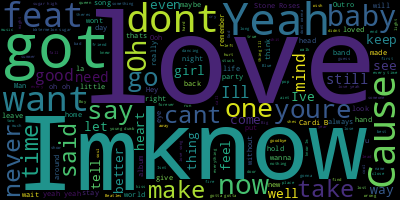

In [20]:
from wordcloud import WordCloud

wc = WordCloud()
lyrics = popular_df.loc[popular_df["lyrics"].notnull(), "lyrics"]
stopwords = lyrics.loc[lyrics.apply(lambda x: len(x) > 2)].values
wc.generate_from_text(text=" ".join(lyrics.values))
wc.to_image()